In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', 150)
from dask import dataframe as dd
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate



In [2]:
X_train= pd.read_csv('X_train.csv')
X_train.head()

,Unnamed: 0,Wh,GId,Ref,RDT,SUM_54,SUM_58,SUM_62,SUM_66,SUM_68,SUM_69,SUM_70,SUM_71,SUM_72,SUM_74,SUM_76,SUM_85,SUM_90,SUM_116,SUM_117,SUM_118,SUM_122,SUM_124,SUM_126,SUM_127,SUM_128,SUM_130,SUM_136,SUM_137,SUM_138,SUM_139,SUM_140,SUM_142,SUM_143,SUM_152,SUM_154,SUM_156,SUM_158,SUM_164,SUM_167,SUM_168,SUM_169,SUM_170,SUM_171,SUM_172,SUM_173,SUM_174,SUM_175,SUM_179,SUM_180,SUM_181,SUM_182,SUM_183,SUM_184,SUM_185,SUM_188,SUM_189,SUM_190,SUM_195,SUM_196,SUM_197,SUM_202,SUM_205,SUM_207,SUM_208,SUM_210,SUM_212,SUM_213,SUM_214,SUM_217,SUM_219,SUM_220,SUM_221,SUM_222,SUM_223,SUM_224,SUM_226,SUM_227,SUM_228,SUM_229,SUM_230,SUM_233,SUM_236,SUM_241,SUM_242,SUM_249,SUM_253,SUM_263,SUM_265,SUM_269,SUM_270,SUM_273,SUM_276,SUM_278,SUM_284,SUM_285,SUM_286,SUM_290,SUM_297,SUM_298,SUM_307,SUM_312,SUM_314,SUM_316,SUM_317,SUM_324,SUM_328,SUM_339,SUM_341,SUM_343,SUM_345,SUM_357,SUM_359,SUM_361,SUM_362,SUM_364,SUM_371,SUM_373,SUM_377,SUM_383,SUM_384,SUM_386,SUM_388,SUM_390,SUM_394,SUM_398,SUM_401,SUM_412,SUM_413,SUM_417,SUM_418,SUM_421,SUM_425,SUM_431,SUM_432,SUM_433,SUM_434,SUM_438,SUM_454,SUM_482,Act_days
0,986371,22,1,1,796.0,0,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,1855392,22,2,8,463.0,0,6,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
2,3617241,22,19,1,158.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,6644727,22,66,1,7.0,0,0,0,1,2,27,1,0,0,0,0,0,0,0,0,0,0,0,0,11,96,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,28
4,5329711,25,96,1,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [3]:
X_train.shape

(5039411, 141)

Пропущенных значений нет

In [4]:
X_train.isna().sum().sum()

0

### Небольшое EDA

Самые популярные приложения для пользователей

In [5]:
X_train.iloc[:,5:140].sum().sort_values(ascending = False).head(10)

SUM_249    414799661
SUM_69     343367767
SUM_371    145622831
SUM_189    136441730
SUM_58      72280137
SUM_242     67027130
SUM_66      61620125
SUM_138     53758133
SUM_373     51208150
SUM_156     49374976
dtype: int64

Пользователи сыгравшие максимальное число раз в игры

In [6]:
nn = X_train.drop(['Wh', 'GId', 'Ref','RDT','Act_days'],axis = 1).set_index('Unnamed: 0')

In [7]:
nn.sum(axis = 1).sort_values(ascending = False).head(10)

Unnamed: 0
173294     90234
173293     89961
173292     89939
4753380    73698
4753379    73695
753512     66767
753510     66759
753509     65155
753508     65152
753507     65151
dtype: int64

У нас нет пользователей, которые были не активны все это время

In [8]:
nn.sum(axis = 1).sort_values(ascending = False).tail(3)


Unnamed: 0
997728     1
6137453    1
3661792    1
dtype: int64

Количество уникальных значений по параметрам пользователя

In [9]:
uniq = ['Wh', 'GId', 'Ref']
for i in uniq:
    print(f'{i} имеет {X_train[i].nunique()} уникальных элементов: {X_train[i].unique()}')

Wh имеет 8 уникальных элементов: [ 22  25 110  55 114  50  37   4]
GId имеет 224 уникальных элементов: [  1   2  19  66  96  31  34 165 174 141 208 170  71   6 192 130 182  72
  14 188 125 126  25 121 190  75  84  48 205 132  51 112 228  60 124 215
 147 106 104 193  67  94 180 148  77 120  90  82 191  93  79  44  35  15
   8  91 145  57  83 181 158   7  22 178 137  85  86   3 196 139  43 198
 218 115 177 122 213 210 187 227  74 209  78  41 116  40  28  70 237  87
 105 214  30  65  97 144 131 140  88 212 171  45 244 195 202 197  64 134
 204 172  52 169   4 175 111  53 286  73  27 109 277  61  29  98 154  56
  47 206  21  46  39 117   5 135 203  81  62 151  76   9 168 102 201 159
  10 298  24 143 279 133 245  50  17 246 248 152 107  33 110 113 123  12
 176  26 108 194 259  95 142  80  16 243 149  59  32 211 207 217 128  13
  11 300 219 284  36 222  68 179 114 199  69 150 129 236 231 184 118 239
 297  49 185 103 230 136 280  55  23 183 220 119  -1 233 289 162 216 299
 173 101 282 263 156 

График активных дней

In [10]:
X_train['Act_days'].value_counts().head(10)

1     1087576
2      685382
3      494386
4      380776
5      301728
6      243067
7      198780
8      166789
9      142296
10     122886
Name: Act_days, dtype: int64

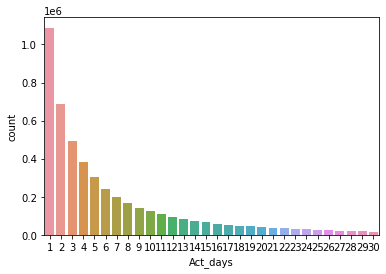

In [11]:
sns.countplot(x='Act_days', order=X_train['Act_days'].value_counts().head(30).index, data=X_train)
pass

In [12]:
X_recom = X_train.drop(['Wh', 'GId', 'Ref','RDT','Act_days'],axis = 1)
X_recom.head()

,Unnamed: 0,SUM_54,SUM_58,SUM_62,SUM_66,SUM_68,SUM_69,SUM_70,SUM_71,SUM_72,SUM_74,SUM_76,SUM_85,SUM_90,SUM_116,SUM_117,SUM_118,SUM_122,SUM_124,SUM_126,SUM_127,SUM_128,SUM_130,SUM_136,SUM_137,SUM_138,SUM_139,SUM_140,SUM_142,SUM_143,SUM_152,SUM_154,SUM_156,SUM_158,SUM_164,SUM_167,SUM_168,SUM_169,SUM_170,SUM_171,SUM_172,SUM_173,SUM_174,SUM_175,SUM_179,SUM_180,SUM_181,SUM_182,SUM_183,SUM_184,SUM_185,SUM_188,SUM_189,SUM_190,SUM_195,SUM_196,SUM_197,SUM_202,SUM_205,SUM_207,SUM_208,SUM_210,SUM_212,SUM_213,SUM_214,SUM_217,SUM_219,SUM_220,SUM_221,SUM_222,SUM_223,SUM_224,SUM_226,SUM_227,SUM_228,SUM_229,SUM_230,SUM_233,SUM_236,SUM_241,SUM_242,SUM_249,SUM_253,SUM_263,SUM_265,SUM_269,SUM_270,SUM_273,SUM_276,SUM_278,SUM_284,SUM_285,SUM_286,SUM_290,SUM_297,SUM_298,SUM_307,SUM_312,SUM_314,SUM_316,SUM_317,SUM_324,SUM_328,SUM_339,SUM_341,SUM_343,SUM_345,SUM_357,SUM_359,SUM_361,SUM_362,SUM_364,SUM_371,SUM_373,SUM_377,SUM_383,SUM_384,SUM_386,SUM_388,SUM_390,SUM_394,SUM_398,SUM_401,SUM_412,SUM_413,SUM_417,SUM_418,SUM_421,SUM_425,SUM_431,SUM_432,SUM_433,SUM_434,SUM_438,SUM_454,SUM_482
0,986371,0,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1855392,0,6,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3617241,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6644727,0,0,0,1,2,27,1,0,0,0,0,0,0,0,0,0,0,0,0,11,96,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,5329711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Переведем в формат 3 столбцов, пользователь приложение потраченные деньги

Также воспользуемся dask для, загрузки больших объемов данных

Также, мы будем в обучающую выборку добавлять не все элементы, а только те, в которых люди играли (потому что 0 означат не то что игра им не понравилась, а то что в игру пока еще не играли)

In [13]:
from dask import dataframe as dd
sd = dd.from_pandas(X_recom, npartitions=3)

In [14]:
sd = sd.melt(id_vars=['Unnamed: 0'])
sd = sd.loc[sd['value']!=0]
X_recom_ = sd.compute()
X_recom_

,Unnamed: 0,variable,value
21,5681462,SUM_54,1
66,4613853,SUM_54,2
101,695184,SUM_54,4
125,5590471,SUM_54,1
132,7066668,SUM_54,1
...,...,...,...
226773359,1500942,SUM_482,5
226773361,4721339,SUM_482,3
226773365,6113790,SUM_482,8
226773386,2138242,SUM_482,14


In [15]:
X_recom_ = X_recom_.merge(X_train[['Unnamed: 0','Wh', 'GId', 'Ref','RDT','Act_days']], on = 'Unnamed: 0',how = 'left')


In [16]:
X_recom_ = X_recom_.rename(columns = {'Unnamed: 0':'userId', 'variable':'itemId',  'value':'rating'})
X_recom_

,userId,itemId,rating,Wh,GId,Ref,RDT,Act_days
0,5681462,SUM_54,1,22,19,1,27.0,6
1,4613853,SUM_54,2,22,125,1,66.0,8
2,695184,SUM_54,4,110,48,1,1032.0,3
3,5590471,SUM_54,1,22,125,1,27.0,26
4,7066668,SUM_54,1,25,192,192,1.0,40
...,...,...,...,...,...,...,...,...
32741705,1500942,SUM_482,5,22,192,1,597.0,24
32741706,4721339,SUM_482,3,22,66,1,59.0,35
32741707,6113790,SUM_482,8,22,71,1,13.0,7
32741708,2138242,SUM_482,14,22,1,1,402.0,102


In [17]:
X_recom_final = X_recom_[['userId','itemId','rating']]

Отнормируем оценки

In [18]:
X_recom_final['rating'] = (X_recom_final['rating']-X_recom_['rating'].min())/(X_recom_['rating'].max()-X_recom_['rating'].min())

In [19]:
X_recom_final['rating'].describe()

count    3.274171e+07
mean     6.627491e-04
std      4.304335e-03
min      0.000000e+00
25%      0.000000e+00
50%      3.472504e-05
75%      1.620502e-04
max      1.000000e+00
Name: rating, dtype: float64

### Подбираем параметры

Выбираем RMSE, потому что мы хотим, оптимизировать разницу между реальным количеством игр и прогнозируемым

In [20]:
reader = Reader(rating_scale=(0, 1))
train = X_recom_final[['userId', 'itemId', 'rating']]
df_auto = Dataset.load_from_df(train, reader)

param_grid = {'n_factors': [20,50], 
             'n_epochs':[7,10,12], 
             'lr_all':[0.005,0.01],
             'reg_all':[0.1,0.2,0.5]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, refit=True)

gs.fit(df_auto)

gs.best_params['rmse']


Измеряем результаты на кросс валидации с лучшими параметрами

Грузится слишком долго (не хватает оперативки), из за большого фрейма данных поэтому выберем часть данных и на ней проведем кросс валидацию 

In [21]:
data = Dataset.load_from_df(X_recom_final[['userId', 'itemId', 'rating']].sample(100000), reader)
algo = SVD(n_factors=20, n_epochs= 10,lr_all= 0.01,reg_all = 0.1, random_state=42)


cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0044  0.0043  0.0046  0.0043  0.0044  0.0044  0.0001  
MAE (testset)     0.0010  0.0011  0.0011  0.0010  0.0011  0.0011  0.0000  
Fit time          0.25    0.27    0.30    0.29    0.28    0.28    0.02    
Test time         0.08    0.08    0.07    0.07    0.07    0.08    0.00    


{'test_rmse': array([0.00435344, 0.00425401, 0.00461255, 0.00432599, 0.00439387]),
 'test_mae': array([0.00104089, 0.00105524, 0.00105679, 0.00102665, 0.00109021]),
 'fit_time': (0.25361061096191406,
  0.2732696533203125,
  0.29919958114624023,
  0.28580808639526367,
  0.2789647579193115),
 'test_time': (0.08388447761535645,
  0.07579874992370605,
  0.07280516624450684,
  0.07499241828918457,
  0.0742652416229248)}

### Запустим теперь результат на трейне и на тесте

In [22]:
data = Dataset.load_from_df(X_recom_final[['userId', 'itemId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_factors=20, n_epochs= 10,lr_all= 0.01,reg_all = 0.1, random_state=42)
# fit on training set
svd.fit(trainset)

In [23]:
train =trainset.build_testset()

In [24]:
pred = svd.test(train)
accuracy.rmse(pred)

RMSE: 0.0041


0.004091095543644707

### Найдем максимальное значение, и относительно его выберем что рекомендовать  


### Также можно было сделать не лучшую рекомендацию а например топ 3-5 рекомендаций и относительно них смотреть, попал ли target в них или не попал. (Точность бы увеличилась)

In [25]:
y= pd.read_csv('y_train.csv')
def recomend(pred,y):
    final_df = pd.DataFrame(pred)
    rezalt = final_df[['uid','iid','est']].groupby(by = ['uid','iid']).max().reset_index()
    rezalt = rezalt.sort_values(by = ['est','uid'],ascending = False)
    rezalt = rezalt.drop_duplicates(subset = 'uid')
    X_numbers = X_train.drop(['Wh', 'GId', 'Ref','RDT','Act_days','Unnamed: 0'],axis = 1)
    X_numbers =(X_numbers.columns).tolist()
    dict_ = {}
    for i in range(len(X_numbers)):
        dict_[X_numbers[i]] = i
    merge_df = pd.DataFrame(list(dict_.items()),
                   columns=['iid', 'Number'])  
    rezalt = rezalt.merge(merge_df,on = 'iid',how = 'left')
    rezalt['Number'] = np.where(rezalt['est']==0,135,rezalt['Number'])
    y.columns = ['uid','Target']
    f = rezalt.merge(y,on = 'uid',how = 'left')
    f['fin'] = np.where(f['Number']==f['Target'],1,0)
    return f,f['fin'].mean()

В финале, мы изменяем просто точность нашего предсказания, потому что классификация многоклассовая, И у нас нет информации о вероятностях. Точность и полнота дадут не лучшую оценку

In [26]:
recomend_,accuracy = recomend(pred,y)
accuracy

0.10663071537526905

In [27]:
recomend_

,uid,iid,est,Number,Target,fin
0,4753379,SUM_242,0.075091,79,95,0
1,4753380,SUM_242,0.071014,79,79,1
2,4753376,SUM_242,0.048168,79,1,0
3,4753377,SUM_242,0.046038,79,8,0
4,753505,SUM_189,0.045463,51,1,0
...,...,...,...,...,...,...
5039406,127335,SUM_433,0.000000,135,135,1
5039407,84770,SUM_71,0.000000,135,135,1
5039408,67380,SUM_179,0.000000,135,61,0
5039409,54692,SUM_142,0.000000,135,135,1


Если учитывать, что мы в многоклассовой задаче, имеем такой хороший процент accuracy, то это очень хорошо 

Если бы мы брали не топ 1 рекомендацию, а например 3-5, то мы бы многократно увеличили наш результат

### Сделаем такую же проверку на тесте

Не хватает памяти загрузки всего теста, поэтому загрузим часть

In [28]:
X_test = pd.read_csv('X_test.csv')
X_test = X_test.sample(100000)

In [29]:
X_test.isna().sum().sum()

0

In [30]:
X_test.shape

(100000, 141)

нормировать мы будем на максимуме и минимуме трейна, чтобы случайано не заглянуть в будущее

In [31]:
X_recom = X_test.drop(['Wh', 'GId', 'Ref','RDT','Act_days'],axis = 1)
sd = dd.from_pandas(X_recom, npartitions=3)
sd = sd.melt(id_vars=['Unnamed: 0'])
sd = sd.loc[sd['value']!=0]
X_recom_test = sd.compute()
X_recom_test = X_recom_test.rename(columns = {'Unnamed: 0':'userId', 'variable':'itemId',  'value':'rating'})
X_recom_final_test = X_recom_test[['userId','itemId','rating']]
X_recom_final_test['rating'] = (X_recom_final_test['rating']-X_recom_['rating'].min())/(X_recom_['rating'].max()-X_recom_['rating'].min())
X_recom_final_test.head()

,userId,itemId,rating
1,170919,SUM_54,0.000058
22,5899146,SUM_54,0.000000
32,5909220,SUM_54,0.000058
36,3872013,SUM_54,0.000150
43,6969147,SUM_54,0.000000


In [32]:
X_recom_final_test['rating'].describe()

count    649080.000000
mean          0.000662
std           0.004303
min           0.000000
25%           0.000000
50%           0.000035
75%           0.000162
max           0.752920
Name: rating, dtype: float64

In [34]:
data = Dataset.load_from_df(X_recom_final_test[['userId', 'itemId', 'rating']], reader)
trainset = data.build_full_trainset()
train =trainset.build_testset()
pred = svd.test(train)

In [36]:
y= pd.read_csv('y_test.csv')
recomend_,accuracy = recomend(pred,y)
accuracy

0.10792

Как мы видим, и на тесте и на трейне мы получили схожие результаты (значит переобучения не возникло)